# Random Walk Performance
# Skip notebook test¶ 

Random walk performance is governed by the length of the paths to find, the number of seeds, and the size or structure of the graph.
This benchmark will use several test graphs of increasingly larger sizes.  While not even multiples in scale, the four test graphs should give an indication of how well Random Walk performs as data size increases.  

### Test Data
Users must run the _dataPrep.sh_ script before running this notebook so that the test files are downloaded

| File Name              | Num of Vertices | Num of Edges |
| ---------------------- | --------------: | -----------: |
| preferentialAttachment |         100,000 |      999,970 |
| dblp-2010              |         326,186 |    1,615,400 |
| coPapersCiteseer       |         434,102 |   32,073,440 |
| as-Skitter             |       1,696,415 |   22,190,596 |

In [1]:
#  Import the modules
import cugraph
import cudf

In [2]:
# system and other
import gc
import os
import time
import random

# MTX file reader
from scipy.io import mmread

import networkx as nx

In [3]:
try: 
    import matplotlib
except ModuleNotFoundError:
    os.system('pip install matplotlib')

import matplotlib.pyplot as plt; plt.rcdefaults()

In [4]:
try: 
    import pybind11
except ModuleNotFoundError:
    os.system('pip install pybind11')
    
import pybind11

In [5]:
try: 
    import walker
except ModuleNotFoundError:
    os.system('pip install graph-walker')

import walker

In [6]:
# Test File
data = {
    'preferentialAttachment' : './data/preferentialAttachment.mtx',
    'dblp'                   : './data/dblp-2010.mtx',
    'coPapersCiteseer'       : './data/coPapersCiteseer.mtx',
    'as-Skitter'             : './data/as-Skitter.mtx'
}

## Read the data and create a graph

In [7]:
# Data reader - the file format is MTX, so we will use the reader from SciPy
def read_data(datafile):
    print('Reading ' + str(datafile) + '...')
    M = mmread(datafile).asfptype()

    _gdf = cudf.DataFrame()
    _gdf['src'] = M.row
    _gdf['dst'] = M.col
    _gdf['wt'] = 1.0
    
    return _gdf

In [8]:
def create_cu_ugraph(_df):
    _g = cugraph.Graph()
    _g.from_cudf_edgelist(_df, source='src', destination='dst', edge_attr='wt', renumber=False)
    return _g

In [9]:
def create_nx_ugraph(_df):
    _gnx = nx.from_pandas_edgelist(_df, source='src', target='dst', edge_attr='wt', create_using=nx.Graph)
    return _gnx

### Define the call to RandomWalk
We are only interested in the runtime, so throw away the results

In [10]:
def run_cu_rw(_G, _seeds, _depth):
    t1 = time.time()
    _, _ = cugraph.random_walks(_G, _seeds, _depth)
    t2 = time.time() - t1
    return t2

In [11]:
def run_wk_rw(_G, _seeds, _depth):
    t1 = time.time()
    _ = walker.random_walks(_G, n_walks=1, walk_len=_depth, start_nodes=_seeds)
    t2 = time.time() - t1
    return t2   
    

## Test 1: Runtime versus path depth

In [12]:
# some parameters
max_depth = 6
num_seeds = 100

# arrays to capture performance gains
names = []

# Two dimension data
time_algo_cu = []       # will be two dimensional
time_algo_wk = []       # will be two dimensional

i = 0
for k,v in data.items():
    time_algo_cu.append([])
    time_algo_wk.append([])
    
    # Saved the file Name
    names.append(k)

    # read data
    gdf = read_data(v)
    pdf = gdf.to_pandas()
    
    # Create the Graphs
    Gcg = create_cu_ugraph(gdf)
    Gnx = create_nx_ugraph(pdf)
        
    num_nodes = Gcg.number_of_nodes()
    nodes = Gcg.nodes().to_array().tolist()

    seeds = random.sample(nodes, num_seeds)

    for j in range (2, max_depth+1) :
        print("\tcuGraph")
        tc = run_cu_rw(Gcg, seeds, j)
        time_algo_cu[i].append(tc)
        
        print("\tWalker", end='')
        tw = run_wk_rw(Gnx, seeds, j)
        time_algo_wk[i].append(tw)

    # update i
    i = i + 1
    print("update i")
    
    del Gcg
    del Gnx


Reading ./data/preferentialAttachment.mtx...
	cuGraph
	WalkerRandom walks - T=2.23s
	cuGraph
	WalkerRandom walks - T=2.48s
	cuGraph
	WalkerRandom walks - T=2.02s
	cuGraph
	WalkerRandom walks - T=2.31s
	cuGraph
	WalkerRandom walks - T=2.01s
update i
Reading ./data/dblp-2010.mtx...
	cuGraph
	WalkerRandom walks - T=4.21s
	cuGraph
	WalkerRandom walks - T=4.03s
	cuGraph
	WalkerRandom walks - T=3.59s
	cuGraph
	WalkerRandom walks - T=3.95s
	cuGraph
	WalkerRandom walks - T=3.68s
update i
Reading ./data/coPapersCiteseer.mtx...
	cuGraph
	WalkerRandom walks - T=59.64s
	cuGraph
	WalkerRandom walks - T=49.43s
	cuGraph
	WalkerRandom walks - T=47.45s
	cuGraph
	WalkerRandom walks - T=54.66s
	cuGraph
	WalkerRandom walks - T=46.96s
update i
Reading ./data/as-Skitter.mtx...
	cuGraph
	WalkerRandom walks - T=53.14s
	cuGraph
	WalkerRandom walks - T=44.36s
	cuGraph
	WalkerRandom walks - T=46.38s
	cuGraph
	WalkerRandom walks - T=41.96s
	cuGraph
	WalkerRandom walks - T=53.18s
update i


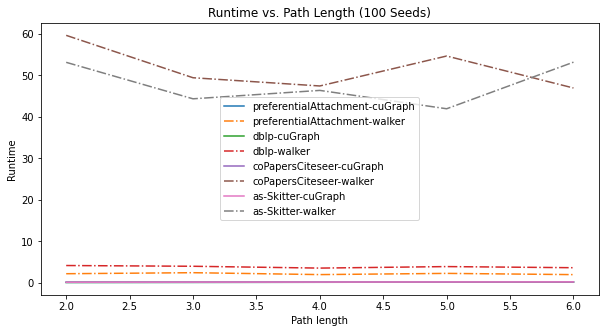

In [13]:
%matplotlib inline
seed_idx = list(range(2,max_depth +1))

plt.figure(figsize=(10,5))

for i in range(len(data)):
    plt.plot(seed_idx, time_algo_cu[i], label = (str(names[i] + "-cuGraph")))

    plt.plot(seed_idx, time_algo_wk[i], label = (str(names[i] + "-walker")),  linestyle='-.')


plt.title(f'Runtime vs. Path Length ({num_seeds} Seeds)')
plt.xlabel('Path length')
plt.ylabel('Runtime')
plt.legend()
plt.show()

In [14]:
del time_algo_cu
del time_algo_wk
gc.collect()

5164

## Test 2: Runtime Speedup versus number of seeds
The number of seeds will be increased over a range in increments of 50.  
The runtime will be the sum of runtime per increment.  Increaing number of seeds by 1 would make for very long execution times 

In [15]:
# some parameters
rw_depth = 4
max_seeds = 1000

# arrays to capture performance gains
names = []

# Two dimension data
time_algo_cu = []       # will be two dimensional
time_algo_wk = []       # will be two dimensional
perf = []               # will be two dimensional

i = 0
for k,v in data.items():
    time_algo_cu.append([])
    time_algo_wk.append([])
    perf.append([])
    
    # Saved the file Name
    names.append(k)

    # read data
    gdf = read_data(v)
    pdf = gdf.to_pandas()
    
    # Create the Graphs
    Gcg = create_cu_ugraph(gdf)
    Gnx = create_nx_ugraph(pdf)
        
    num_nodes = Gcg.number_of_nodes()
    nodes = Gcg.nodes().to_array().tolist()
    
    print('\t', end='')
    for j in range (50, max_seeds +1, 50) :
        print('.', end='')
        seeds = random.sample(nodes, j)
        tc = run_cu_rw(Gcg, seeds, rw_depth)
        tw = run_wk_rw(Gnx, seeds, rw_depth)
        
        time_algo_cu[i].append(tc)
        time_algo_wk[i].append(tw)        
        perf[i].append(tw/tc)
        

    # update i
    i = i + 1
    print(" ")
    
    del Gcg
    del Gnx


Reading ./data/preferentialAttachment.mtx...
	.Random walks - T=2.28s
.Random walks - T=2.29s
.Random walks - T=2.28s
.Random walks - T=2.21s
.Random walks - T=1.95s
.Random walks - T=2.38s
.Random walks - T=2.00s
.Random walks - T=2.19s
.Random walks - T=1.99s
.Random walks - T=2.40s
.Random walks - T=1.95s
.Random walks - T=2.17s
.Random walks - T=1.95s
.Random walks - T=2.39s
.Random walks - T=1.97s
.Random walks - T=2.23s
.Random walks - T=2.63s
.Random walks - T=4.08s
.Random walks - T=3.44s
.Random walks - T=3.77s
 
Reading ./data/dblp-2010.mtx...
	.Random walks - T=6.61s
.Random walks - T=6.57s
.Random walks - T=6.48s
.Random walks - T=6.69s
.Random walks - T=6.11s
.Random walks - T=6.18s
.Random walks - T=4.98s
.Random walks - T=5.64s
.Random walks - T=3.83s
.Random walks - T=4.28s
.Random walks - T=4.34s
.Random walks - T=4.14s
.Random walks - T=3.79s
.Random walks - T=4.37s
.Random walks - T=4.00s
.Random walks - T=3.66s
.Random walks - T=4.01s
.Random walks - T=3.67s
.Random

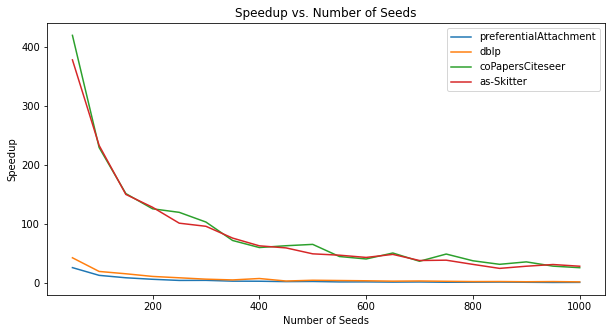

In [16]:
%matplotlib inline
seed_idx = list(range (50, max_seeds +1, 50))

plt.figure(figsize=(10,5))

for i in range(len(data)):
    plt.plot(seed_idx, perf[i], label = names[i] )

plt.title('Speedup vs. Number of Seeds')
plt.xlabel('Number of Seeds')
plt.ylabel('Speedup')
plt.legend()
plt.show()

In [17]:
del time_algo_cu
gc.collect()

3786

-----
Copyright (c) 2021, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.